In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:

dx = 1
dy = 1
nx = 3
ny = 3

source = np.array([[0, 0.5], [0, 1.5], [0, 2.5]])
receiver = np.array([[3, 0.5], [3, 1.5], [3, 2.5]])

In [ ]:
N = 1001
ns = source.shape[0]
nr = receiver.shape[0]

G = np.zeros((ns * nr, nx * ny))

# Iteration to fill the Kernel matrix G
for i in range(ns):
    for j in range(nr):
        # Row index for matrix G (0-based)
        ij = i * nr + j
        # Distance
        dist = np.linalg.norm(receiver[j] - source[i])
        dd = dist / N
        
        # Compute cosine components scaled by dd
        cosx = (receiver[j, 0] - source[i, 0]) / dist * dd
        cosy = (receiver[j, 1] - source[i, 1]) / dist * dd
        
        # Initial position
        x0 = source[i, 0]
        y0 = source[i, 1]
        
        # Initial block index at source position (1-based)
        idx = int(np.ceil(x0 / dx))
        if np.isclose(x0 % dx, 0.0):
            idx += 1
        idy = int(np.ceil(y0 / dy))
        if np.isclose(y0 % dy, 0.0):
            idy += 1
        indx0 = (idy - 1) * ny + idx
        
        d1 = 0.0
        
        for k in range(1, N + 2):
            # Position along the ray
            xi = cosx * k  # Since x0 = 0 for all sources
            yi = cosy * k + y0
            
            # Find block index (1-based, no boundary adjustment in loop)
            idx = int(np.ceil(xi / dx))
            idy = int(np.ceil(yi / dy))
            indx = (idy - 1) * ny + idx
            
            if indx == indx0:
                d1 += dd
            else:
                # Assign to previous block (convert to 0-based for array)
                G[ij, indx0 - 1] = d1
                d1 = dd
                indx0 = indx

# The resulting matrix G (printed with 4 decimal places to match the example)
print(np.round(G, 4))


[[0.998  1.001  1.001  0.     0.     0.     0.     0.     0.    ]
 [1.052  0.5276 0.     0.     0.5276 1.0551 0.     0.     0.    ]
 [0.9005 0.     0.     0.299  1.2031 0.299  0.     0.     0.9041]
 [0.     0.5276 1.0551 1.052  0.5276 0.     0.     0.     0.    ]
 [0.     0.     0.     0.998  1.001  1.001  0.     0.     0.    ]
 [0.     0.     0.     1.052  0.5276 0.     0.     0.5276 1.0551]
 [0.     0.     0.9041 0.299  1.2031 0.299  0.9005 0.     0.    ]
 [0.     0.     0.     0.     0.5276 1.0551 1.052  0.5276 0.    ]
 [0.     0.     0.     0.     0.     0.     0.998  1.001  1.001 ]]


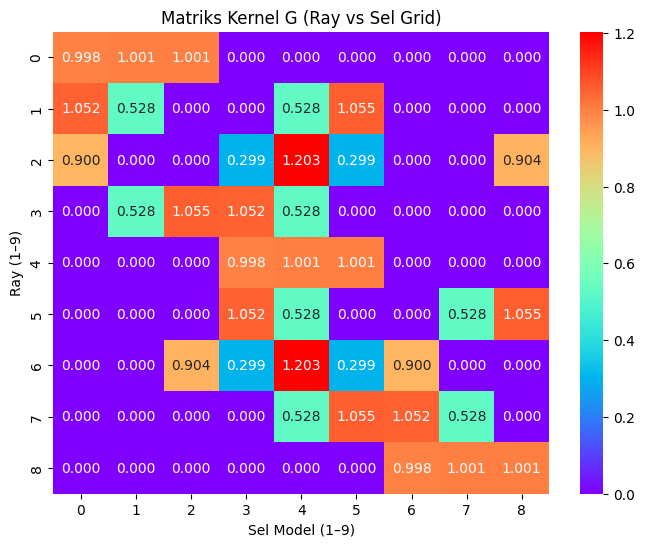

In [22]:
# Visualisasi kernel sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(G, annot=True, fmt=".3f", cmap="rainbow", cbar=True)

plt.title("Matriks Kernel G (Ray vs Sel Grid)")
plt.xlabel("Sel Model (1–9)")
plt.ylabel("Ray (1–9)")
plt.show()

In [23]:
d = np.array([3., 3.1622777, 3.0655513, 3.1622777, 3., 3.1622777, 3.0655513, 3.1622777, 3.], dtype=float)

In [24]:
A = G.T @ G
B = G.T @ d
A_inv = np.linalg.inv(A)

In [25]:
m = A_inv @ B
pd.DataFrame(m)

,0
0,6.917217
1,-15.007089
2,7.105907
3,-1.289477
4,3.954713
5,1.830752
6,-3.912868
7,6.000000
8,-2.000000


In [26]:
def equation(G, d, epsilon):
    I = G.shape[1]
    A = (G.T @ G) + (epsilon**2) * np.eye(I)
    B = G.T @ d
    m = np.linalg.solve(A, B)
    return m

In [27]:
m_true = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=float)

In [28]:
eps_values = np.arange(0.0001, 100.01, 0.001)
results = []

In [29]:
for eps in eps_values:
    m = equation(G, d, eps)
    residual_norm = np.linalg.norm((G @ m) - d)
    model_norm = np.linalg.norm(((m - np.mean(m)).T) @ (m - np.mean(m)))
    results.append([eps, residual_norm, model_norm])

In [30]:
df = pd.DataFrame(results, columns=["epsilon", "residual_norm", "model_norm"])

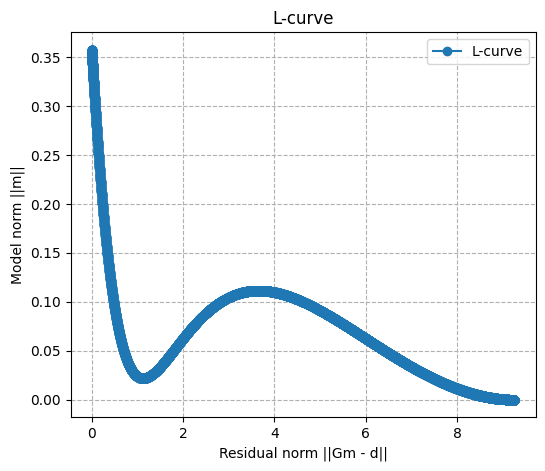

In [31]:
plt.figure(figsize=(6, 5))
plt.plot(df["residual_norm"], df["model_norm"], 'o-', label="L-curve")

plt.xlabel("Residual norm ||Gm - d||")
plt.ylabel("Model norm ||m||")
plt.title("L-curve")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [32]:
m_true = np.ones(G.shape[1]) 

errors = []
for eps in eps_values:
    m = equation(G, d, eps)
    residual_norm = np.linalg.norm(G @ m - d)
    model_norm = np.linalg.norm(((m - np.mean(m)).T) @ (m - np.mean(m)))
    model_error = np.linalg.norm(m - m_true)
    results.append([eps, residual_norm, model_norm, model_error])
    errors.append(model_error)

df = pd.DataFrame(results, columns=["epsilon", "residual_norm", "model_norm", "model_error"])

best_idx = np.argmin(df["model_error"])
best_epsilon = df.loc[best_idx, "epsilon"]
residual_best = df.loc[best_idx, "residual_norm"]
model_best = df.loc[best_idx, "model_norm"]
print("Best epsilon (berdasarkan model error) =", best_epsilon)

Best epsilon (berdasarkan model error) = 0.7431


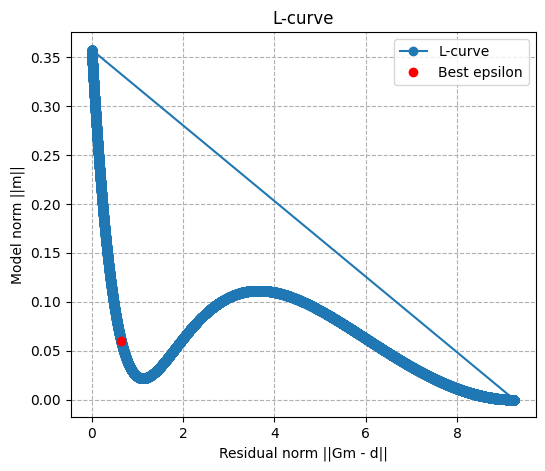

In [33]:
plt.figure(figsize=(6, 5))
plt.plot(df["residual_norm"], df["model_norm"], 'o-', label="L-curve")
plt.plot(residual_best, model_best, 'ro', label="Best epsilon")

plt.xlabel("Residual norm ||Gm - d||")
plt.ylabel("Model norm ||m||")
plt.title("L-curve")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [34]:
A = (G.T @ G) + (best_epsilon**2) * np.eye(9)
B = G.T @ d
A_inv = np.linalg.inv(A)

In [35]:
m = A_inv @ B
pd.DataFrame(m)

,0
0,0.859597
1,0.978278
2,0.862457
3,1.031374
4,0.802273
5,1.033915
6,0.859597
7,0.978278
8,0.862457
